In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
# Read and vectorize data
df = pd.read_csv('bball_data.csv')

player_vectors = df.pivot(index='Player', columns='Skill', values='Value')
skill_order = ['Playmaking', 'Shooting', 'Dribbling', 'Rebounding', 'Defense', 'Athleticism', "Height"]
player_vectors = player_vectors[skill_order]
X = player_vectors.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Shape of feature vectors:", X.shape)
print("\nFirst few player vectors:\n", X[:3])

Shape of feature vectors: (15, 7)

First few player vectors:
 [[-0.62545827 -0.40866693  0.30211725 -0.20165342  0.98930997  1.03743822
  -0.21111193]
 [ 1.32909882  1.34276277  1.60671444 -0.58944845  0.5011636   1.41931731
  -0.21111193]
 [-0.31272913 -1.0967286  -0.93381694 -0.20165342 -0.76801695 -1.06289682
  -1.00278165]]


# Algorithms

1) K-means
2) Greedy

In [9]:
# K-means clustering

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Calculate number of clusters needed for 3 players per cluster
n_players = len(X)
n_clusters = n_players // 3

# Initial clustering with more clusters than needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

# Get cluster centers and distances
centers = kmeans.cluster_centers_
distances = pairwise_distances(X, centers)

# Assign exactly 3 players to each cluster
cluster_labels = np.full(len(X), -1)
for cluster in range(n_clusters):
    # Get distances to current cluster center
    cluster_distances = distances[:, cluster]
    
    # Find 3 closest unassigned players
    unassigned_mask = cluster_labels == -1
    closest_players = np.argsort(cluster_distances[unassigned_mask])[:3]
    unassigned_indices = np.where(unassigned_mask)[0]
    cluster_labels[unassigned_indices[closest_players]] = cluster

# Print clusters
for cluster in range(n_clusters):
    print(f"\nCluster {cluster + 1}:")
    cluster_mask = cluster_labels == cluster
    cluster_players = player_vectors.index[cluster_mask]
    for player in cluster_players:
        print(f"  {player}")


Cluster 1:
  Diego
  Jackson
  Logan

Cluster 2:
  Ethan L
  Gavin
  William

Cluster 3:
  Aryan
  Max C
  Rohan

Cluster 4:
  Izzy
  Max R
  Oliver

Cluster 5:
  James
  Kian
  Swain


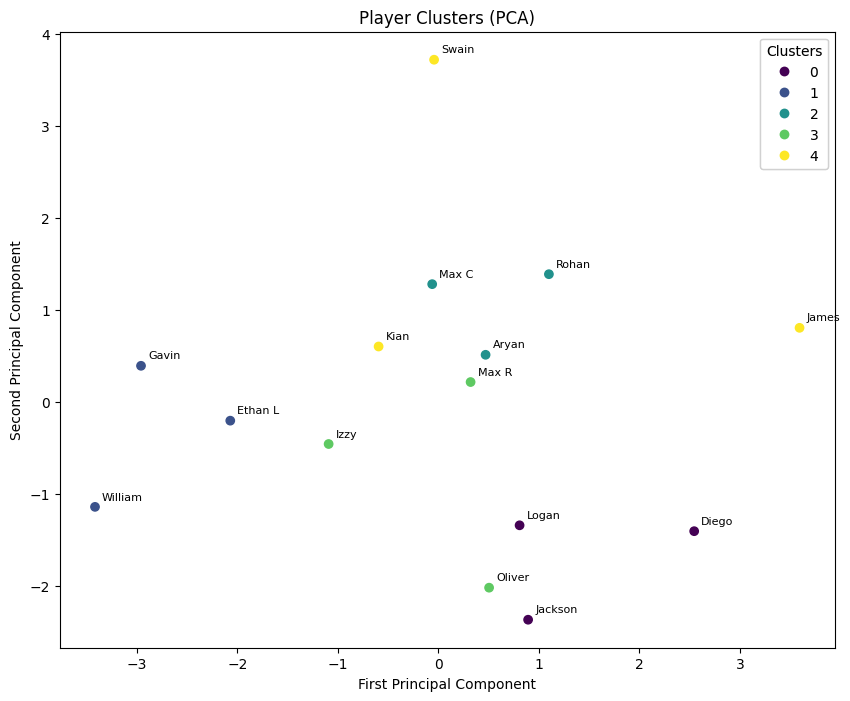

In [10]:
# Perform PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="viridis")
plt.title('Player Clusters (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters")
plt.gca().add_artist(legend1)

# Add player names as annotations
for i, player in enumerate(player_vectors.index):
    plt.annotate(player, (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.show()


In [11]:
# Create DataFrame with players and clusters
cluster_df = pd.DataFrame({
    'Player': player_vectors.index,
    'Cluster': cluster_labels
})

# Add sum column
cluster_df['Sum'] = 0  # Initialize sum column
players = df['Player'].unique()
for player in players:
    player_data = df[df['Player'] == player]
    skill_sum = player_data['Value'].sum()
    cluster_df.loc[cluster_df['Player'] == player, 'Sum'] = skill_sum

# Sort by cluster and sum
cluster_df = cluster_df.sort_values(['Cluster', 'Sum'])

cluster_df.reset_index(inplace=True, drop=True)

cluster_df

,Player,Cluster,Sum
0,Jackson,0,96.6
1,Logan,0,98.8
2,Diego,0,104.8
3,William,1,84.1
4,Gavin,1,87.1
5,Ethan L,1,89.7
6,Max C,2,97.4
7,Aryan,2,98.2
8,Rohan,2,104.3
9,Izzy,3,96.9


In [32]:
# Strategy 1

# Sort clusters by difference between max and min skill
# Randomly assign players in the first cluster to a team
# The team with the lowest cumulative skill receives the best player from the next cluster
# The team with the middle cumulativeskill receives the second best player from the next cluster
# The team with the highest cumulative skill receives the third best player from the next cluster

# --------------------------------------------------------------------------------------------

# Sort clusters by difference between max and min skill

clusters = cluster_df['Cluster'].unique()

differences = []

for cluster in clusters:
    temp_df = cluster_df[cluster_df['Cluster'] == cluster]
    temp_df = temp_df.sort_values('Sum')
    temp_df = temp_df.reset_index(drop=True)
    # print(temp_df)
    differences.append(temp_df['Sum'].max() - temp_df['Sum'].min())
    differences.append(temp_df['Sum'].max() - temp_df['Sum'].min())
    differences.append(temp_df['Sum'].max() - temp_df['Sum'].min())

cluster_df['Difference'] = differences

cluster_df.sort_values(by='Difference', ascending=False, inplace=True)

# --------------------------------------------------------------------------------------------

# Create teams

teams = [[], [], []]

clusters = cluster_df['Cluster'].unique()

for cluster in clusters:
    # Calculate the max, middle, and min sum for each cluster
    high = cluster_df[cluster_df['Cluster'] == cluster]['Sum'].max()
    middle = cluster_df[cluster_df['Cluster'] == cluster]['Sum'].median()
    low = cluster_df[cluster_df['Cluster'] == cluster]['Sum'].min()

    # Calculate the cumulative sum of each team
    team_sums = [sum(teams[0]), sum(teams[1]), sum(teams[2])]
    sorted_indices = sorted(range(len(team_sums)), key=lambda k: team_sums[k])
    lowest_cumulative_sum_index = sorted_indices[0]
    middle_cumulative_sum_index = sorted_indices[1]
    highest_cumulative_sum_index = sorted_indices[2]

    teams[lowest_cumulative_sum_index].append(high)
    teams[middle_cumulative_sum_index].append(middle)
    teams[highest_cumulative_sum_index].append(low)

print(f"\nTotal team scores: {[sum(team) for team in teams]}")
print(f"Teams: {teams}")


Total team scores: [489.8, 488.0, 490.8]
Teams: [[112.0, 96.6, 97.4, 84.1, 99.7], [100.9, 98.8, 104.3, 87.1, 96.9], [96.30000000000001, 104.8, 98.2, 89.7, 101.8]]


In [34]:
# Convert team sums back to player names
named_teams = [[], [], []]

for cluster in clusters:
    cluster_players = cluster_df[cluster_df['Cluster'] == cluster].sort_values('Sum')
    
    # Find which team got which skill level from this cluster
    for team_idx, team in enumerate(teams):
        player_sum = [sum for sum in team if sum in cluster_players['Sum'].values][0]
        player = cluster_players[cluster_players['Sum'] == player_sum]['Player'].values[0]
        named_teams[team_idx].append(player)

print("\nTeams by player names:")
for i, team in enumerate(named_teams):
    print(f"Team {i+1}: {team}")


Teams by player names:
Team 1: ['James', 'Jackson', 'Max C', 'William', 'Oliver']
Team 2: ['Swain', 'Logan', 'Rohan', 'Gavin', 'Izzy']
Team 3: ['Kian', 'Diego', 'Aryan', 'Ethan L', 'Max R']


In [35]:
# Strategy 2

# Explore the entire combination space and find the optimal team
# Total 6^4 (1296) combinations

cluster_df

,Player,Cluster,Sum,Difference
12,Kian,4,96.3,15.7
13,Swain,4,100.9,15.7
14,James,4,112.0,15.7
0,Jackson,0,96.6,8.2
1,Logan,0,98.8,8.2
2,Diego,0,104.8,8.2
6,Max C,2,97.4,6.9
7,Aryan,2,98.2,6.9
8,Rohan,2,104.3,6.9
3,William,1,84.1,5.6
